In [ ]:
# Install Ultralytics (YOLOv8), OpenCV, Matplotlib, Pandas, Albumentations
!pip install -q ultralytics opencv-python-headless matplotlib numpy pandas albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()   # <-- select your halal-logo.zip

# Unzip (replace the name if your zip has a different name)
!unzip -q "/content/halal logo.v5i.yolov8.zip" -d /content/dataset

# Quick check of folder structure
!ls /content/dataset

Saving halal logo.v5i.yolov8.zip to halal logo.v5i.yolov8.zip
unzip:  cannot find or open halal-logo.zip, halal-logo.zip.zip or halal-logo.zip.ZIP.
ls: cannot access '/content/dataset': No such file or directory


In [ ]:
!unzip -q "/content/halal logo.v5i.yolov8.zip" -d /content/dataset

In [ ]:
!ls /content/dataset

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
import yaml, os

with open('/content/dataset/data.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

class_names = cfg['names']
print("Classes:", class_names)
print("Number of classes:", len(class_names))

Classes: ['Malaysiahalal', 'Thailandhalal', 'chinahalal', 'europehalal', 'indiahalal', 'indonesiahalal', 'koreanhalal', 'singaporehalal', 'switzerlandhalal', 'unverifiedhalal', 'vietnamhalal']
Number of classes: 11


In [ ]:
train_img_dir   = '/content/dataset/train/images'
train_label_dir = '/content/dataset/train/labels'
val_img_dir     = '/content/dataset/valid/images'      # Roboflow uses "valid"
val_label_dir   = '/content/dataset/valid/labels'

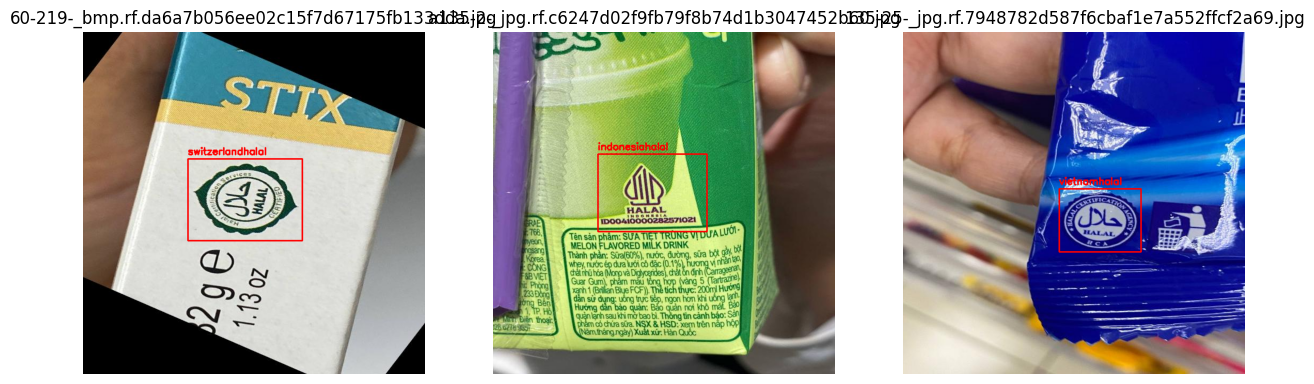

In [ ]:
import cv2, matplotlib.pyplot as plt, random, os

def plot_samples(img_dir, label_dir, class_names, n=3):
    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.png'))]
    samples = random.sample(imgs, min(n, len(imgs)))

    fig, axs = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
    if len(samples)==1: axs = [axs]

    for ax, fname in zip(axs, samples):
        img_path  = os.path.join(img_dir, fname)
        lbl_path  = os.path.join(label_dir, os.path.splitext(fname)[0] + '.txt')
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        if os.path.exists(lbl_path):
            with open(lbl_path) as f:
                for line in f:
                    cls, cx, cy, bw, bh = map(float, line.split())
                    cls = int(cls)
                    x1 = int((cx-bw/2)*w); y1 = int((cy-bh/2)*h)
                    x2 = int((cx+bw/2)*w); y2 = int((cy+bh/2)*h)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                    cv2.putText(img, class_names[cls], (x1, y1-8),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
        ax.imshow(img); ax.axis('off'); ax.set_title(fname)
    plt.show()

plot_samples(train_img_dir, train_label_dir, class_names)

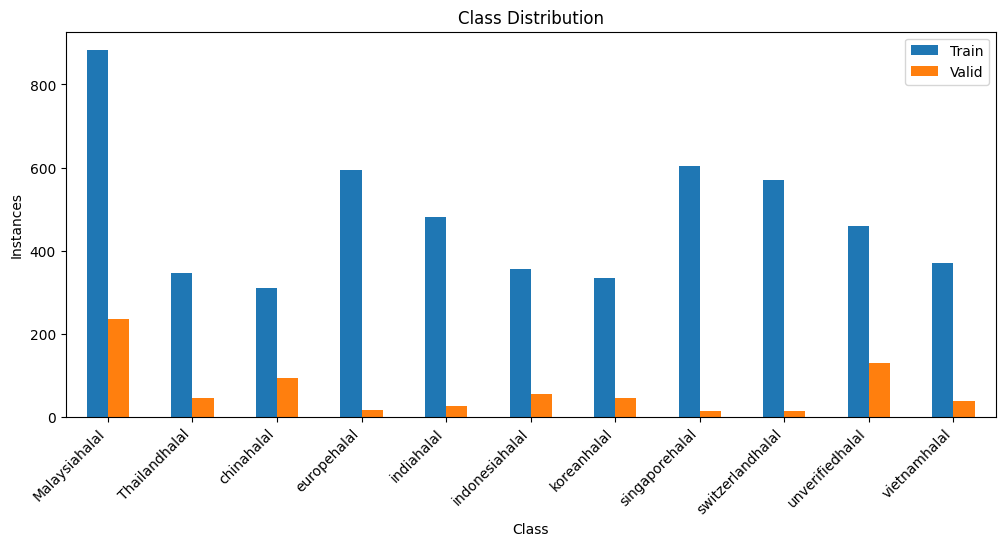

,Class,Train,Valid
0,Malaysiahalal,883,234
1,Thailandhalal,345,44
2,chinahalal,311,92
3,europehalal,595,16
4,indiahalal,480,26
5,indonesiahalal,356,55
6,koreanhalal,334,46
7,singaporehalal,603,13
8,switzerlandhalal,571,13
9,unverifiedhalal,459,129


In [ ]:
import numpy as np, pandas as pd

def count_classes(label_dir, n_classes):
    counts = np.zeros(n_classes, dtype=int)
    for txt in [f for f in os.listdir(label_dir) if f.endswith('.txt')]:
        with open(os.path.join(label_dir, txt)) as f:
            for line in f:
                # Safely convert class ID to int, handling 'X.0' format
                counts[int(float(line.split()[0]))] += 1
    return counts

train_counts = count_classes(train_label_dir, len(class_names))
valid_counts = count_classes(val_label_dir, len(class_names))

df = pd.DataFrame({
    'Class': class_names,
    'Train': train_counts,
    'Valid': valid_counts
})
df.plot(x='Class', kind='bar', figsize=(12,5), title='Class Distribution')
plt.ylabel('Instances'); plt.xticks(rotation=45, ha='right'); plt.show()
display(df)

In [ ]:
min_c = train_counts.min()
max_c = train_counts.max()
ratio = max_c / min_c if min_c>0 else float('inf')
print(f"Imbalance ratio (max/min): {ratio:.2f}")

BALANCE_THRESHOLD = 2.0
if ratio > BALANCE_THRESHOLD:
    print("Imbalanced → augmenting minority classes")

    import albumentations as A
    from shutil import copyfile
    import numpy as np # Added numpy import for clip function

    # Augmentation pipeline (YOLO format)
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.3),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    target = int(train_counts.mean())           # bring every class to average
    aug_img_dir = '/content/dataset/train/aug_images'
    aug_lbl_dir = '/content/dataset/train/aug_labels'
    os.makedirs(aug_img_dir, exist_ok=True)
    os.makedirs(aug_lbl_dir, exist_ok=True)

    # ---- augmentation loop ----
    for cls in range(len(class_names)):
        if train_counts[cls] >= target: continue
        needed = target - train_counts[cls]
        candidate_imgs = []
        for txt_file in os.listdir(train_label_dir):
            if txt_file.endswith('.txt'):
                with open(os.path.join(train_label_dir, txt_file)) as f:
                    # Reset file pointer for each read
                    f.seek(0)
                    # Safely convert class ID to int, handling 'X.0' format
                    if any(int(float(l.split()[0]))==cls for l in f):
                        candidate_imgs.append(txt_file.replace('.txt',''))

        added = 0
        while added < needed and candidate_imgs:
            base = random.choice(candidate_imgs)
            img_path = os.path.join(train_img_dir, f"{base}.jpg")
            if not os.path.exists(img_path):
                img_path = img_path.replace('.jpg','.png') # Handle .png images
            lbl_path = os.path.join(train_label_dir, f"{base}.txt")

            img = cv2.imread(img_path)
            bboxes_yolo, labels = [], []

            if img is None: # Check if image loaded successfully
                print(f"Warning: Could not read image {img_path}. Skipping.")
                candidate_imgs.remove(base) # Remove problematic image from candidates
                continue

            with open(lbl_path) as f:
                for line in f:
                    parts = line.split()
                    # Safely convert class ID to int, handling 'X.0' format
                    current_class_id = int(float(parts[0]))
                    polygon_coords_flat = [float(x) for x in parts[1:]]

                    # Convert polygon coordinates to YOLO bounding box format (cx, cy, w, h)
                    xs = polygon_coords_flat[::2]
                    ys = polygon_coords_flat[1::2]

                    # Calculate min/max for bounding box
                    min_x = min(xs)
                    max_x = max(xs)
                    min_y = min(ys)
                    max_y = max(ys)

                    # Convert to YOLO format: center_x, center_y, width, height
                    bbox_center_x = (min_x + max_x) / 2
                    bbox_center_y = (min_y + max_y) / 2
                    bbox_width = max_x - min_x
                    bbox_height = max_y - min_y

                    # Clip coordinates to be within [0, 1] range to prevent errors
                    bbox_center_x = np.clip(bbox_center_x, 0.0, 1.0)
                    bbox_center_y = np.clip(bbox_center_y, 0.0, 1.0)
                    bbox_width = np.clip(bbox_width, 0.0, 1.0)
                    bbox_height = np.clip(bbox_height, 0.0, 1.0)

                    # Only add bounding boxes with valid dimensions
                    if bbox_width > 0 and bbox_height > 0:
                        labels.append(current_class_id)
                        bboxes_yolo.append([bbox_center_x, bbox_center_y, bbox_width, bbox_height])
                    else:
                        print(f"Warning: Skipping bounding box with zero width or height for image {base}. Label: {line.strip()}")

            if not bboxes_yolo: # Skip if no valid bboxes were extracted
                print(f"Warning: No valid bounding boxes found in {lbl_path}. Skipping augmentation for this image.")
                candidate_imgs.remove(base)
                continue

            try:
                transformed = aug(image=img, bboxes=bboxes_yolo, class_labels=labels)
            except ValueError as e:
                print(f"Error during augmentation for {base}: {e}")
                print(f"Original bboxes passed to augmentation: {bboxes_yolo}")
                candidate_imgs.remove(base) # Remove problematic image from candidates
                continue

            new_img = transformed['image']
            new_boxes = transformed['bboxes'] # These will be in YOLO format [cx,cy,w,h]
            new_labels = transformed['class_labels']

            new_name = f"aug_{added}_{base}"
            cv2.imwrite(os.path.join(aug_img_dir, f"{new_name}.jpg"), new_img)
            with open(os.path.join(aug_lbl_dir, f"{new_name}.txt"), 'w') as f:
                for c,box in zip(new_labels, new_boxes):
                    # Ensure box coordinates are floats for writing
                    f.write(f"{int(c)} {' '.join(map(str, [float(coord) for coord in box]))}\n") # Cast class label to int
            added += 1

    # Merge augmented data into original train folders
    !cp {aug_img_dir}/* {train_img_dir}/
    !cp {aug_lbl_dir}/* {train_label_dir}/
    print("Augmentation finished & merged.")
else:
    print("Dataset is balanced – no extra augmentation needed.")

Imbalance ratio (max/min): 26.33
Imbalanced → augmenting minority classes
Augmentation finished & merged.


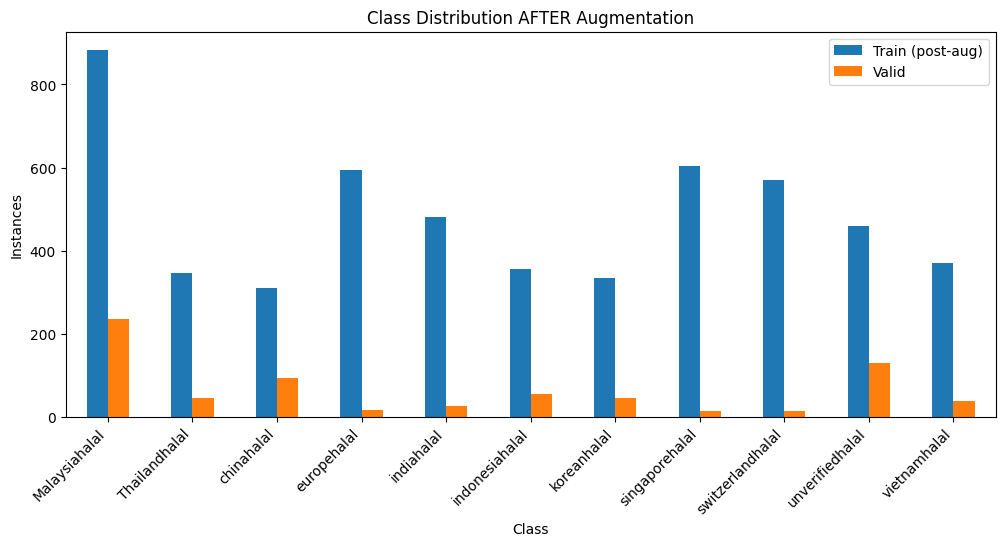

,Class,Train (post-aug),Valid
0,Malaysiahalal,883,234
1,Thailandhalal,345,44
2,chinahalal,311,92
3,europehalal,595,16
4,indiahalal,480,26
5,indonesiahalal,356,55
6,koreanhalal,334,46
7,singaporehalal,603,13
8,switzerlandhalal,571,13
9,unverifiedhalal,459,129


In [ ]:
train_counts_post = count_classes(train_label_dir, len(class_names))
df2 = pd.DataFrame({
    'Class': class_names,
    'Train (post-aug)': train_counts_post,
    'Valid': valid_counts
})
df2.plot(x='Class', kind='bar', figsize=(12,5), title='Class Distribution AFTER Augmentation')
plt.ylabel('Instances'); plt.xticks(rotation=45, ha='right'); plt.show()
display(df2)

In [ ]:
from ultralytics import YOLO

# Use yolov8s (good speed/accuracy); change to yolov8n for faster, yolov8m for better
model = YOLO('yolov8s.pt')

results = model.train(
    data='/content/dataset/data.yaml',
    epochs=10,          # you can lower to 50 if you see early convergence
    imgsz=240,
    batch=16,
    name='halal_logo_yolov8',
    augment=True,       # mosaic, flip, HSV, etc.
    patience=15,
    device=0            # GPU
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=240, int8=False, iou=0.7, keras=False, 

Running inference on 5 sample images...

0: 256x256 1 Malaysiahalal, 9.7ms
1: 256x256 1 chinahalal, 9.7ms
2: 256x256 1 Malaysiahalal, 9.7ms
3: 256x256 1 chinahalal, 9.7ms
4: 256x256 2 unverifiedhalals, 9.7ms
Speed: 0.9ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)


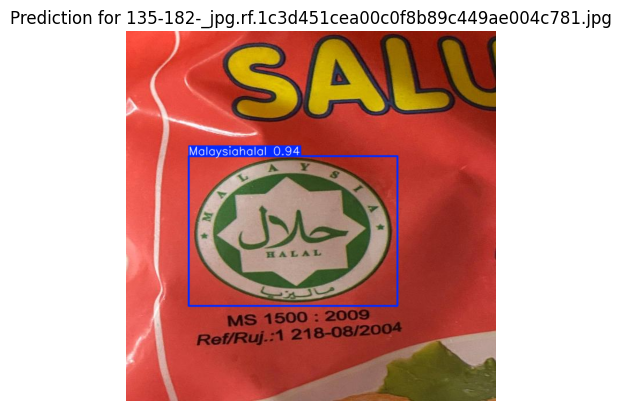

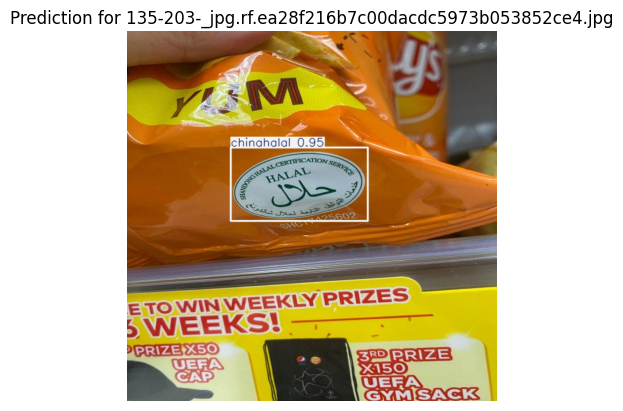

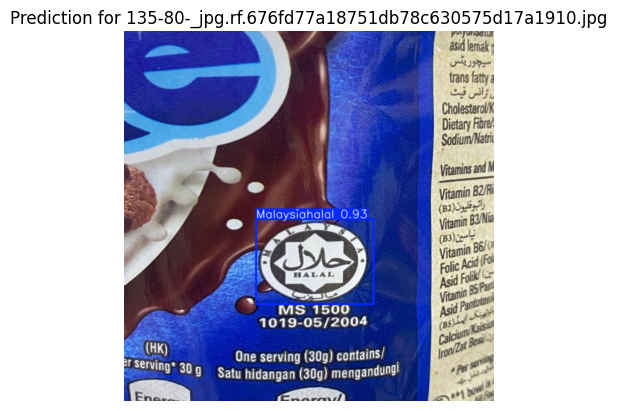

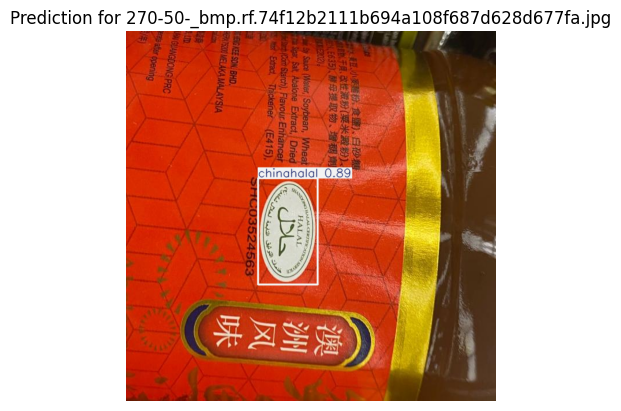

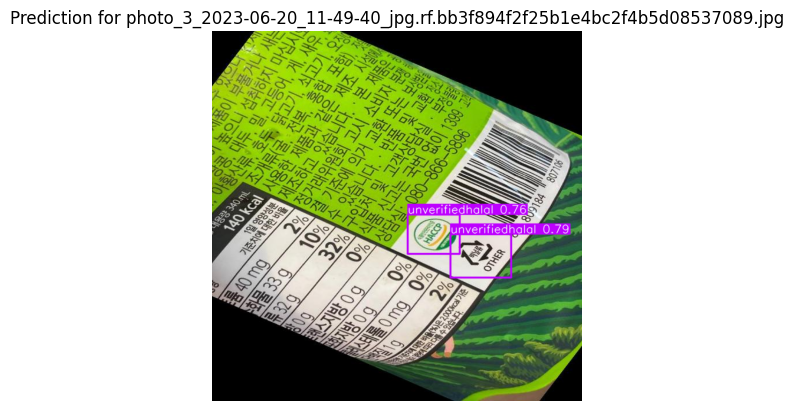

In [ ]:
import os
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the best trained model
model = YOLO('/content/runs/detect/halal_logo_yolov8/weights/best.pt')

# Get some random images from the validation set
val_img_dir = '/content/dataset/valid/images'
val_images = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.lower().endswith(('.jpg', '.png'))]
sample_images = random.sample(val_images, min(5, len(val_images))) # Select up to 5 random images

print(f"Running inference on {len(sample_images)} sample images...")
# Run inference on the selected images
results = model.predict(source=sample_images, conf=0.25) # conf=0.25 is default

# Plot the results
for i, result in enumerate(results):
    im_bgr = result.plot()  # plot a BGR numpy array of predictions
    im_rgb = plt.imshow(im_bgr[..., ::-1])  # RGB-convert BGR image
    plt.title(f"Prediction for {os.path.basename(sample_images[i])}")
    plt.axis('off')
    plt.show()

In [ ]:
metrics = model.val()
print(f"mAP@0.5       : {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95  : {metrics.box.map:.4f}")

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2083.4±865.6 MB/s, size: 62.3 KB)
val: Scanning /content/dataset/valid/labels.cache... 624 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 624/624 1.1Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 705. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 8.9it/s 4.4s
                   all        624        705      0.854      0.924      0.959      0.735
         Malaysiahalal        234        234       0.98      0.996      0.995      0.892
         Thailandhalal         42         44      0.859      0.977      0.978      0.691
            chinahalal         92    

In [ ]:
from ultralytics import YOLO
import os

# Load your trained model (from previous run)
model = YOLO('/content/runs/detect/halal_logo_yolov8/weights/best.pt')  # Path to your best.pt

# Save a copy (optional: rename or compress)
model.save('halal_logo_detector.pt')  # Saves to /content/

# Download to your local machine (for Streamlit repo)
from google.colab import files
files.download('halal_logo_detector.pt')

# Optional: Export to ONNX too (for future-proofing)
model.export(format='onnx')
files.download('/content/runs/detect/halal_logo_yolov8/weights/best.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from '/content/runs/detect/halal_logo_yolov8/weights/best.pt' with input shape (1, 3, 256, 256) BCHW and output shape(s) (1, 15, 1344) (21.4 MB)

ONNX: starting export with onnx 1.20.0rc1 opset 22...
WARNING ⚠️ ONNX: simplifier failure: module 'onnx.helper' has no attribute 'float32_to_bfloat16'
ONNX: export success ✅ 1.3s, saved as '/content/runs/detect/halal_logo_yolov8/weights/best.onnx' (42.5 MB)

Export complete (2.0s)
Results saved to /content/runs/detect/halal_logo_yolov8/weights
Predict:         yolo predict task=detect model=/content/runs/detect/halal_logo_yolov8/weights/best.onnx imgsz=256  
Validate:        yolo val task=detect model=/content/runs/detect/halal_logo_yolov8/weights/best.onnx imgsz=256 data=/content/dataset/data.yaml  
Visualize:       https://netron.app


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.export(format='onnx')   # saves best.onnx in /content/runs/detect/halal_logo_yolov8/weights/

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from '/content/runs/detect/halal_logo_yolov8/weights/best.pt' with input shape (1, 3, 256, 256) BCHW and output shape(s) (1, 15, 1344) (21.4 MB)

ONNX: starting export with onnx 1.20.0rc1 opset 22...
WARNING ⚠️ ONNX: simplifier failure: module 'onnx.helper' has no attribute 'float32_to_bfloat16'
ONNX: export success ✅ 1.2s, saved as '/content/runs/detect/halal_logo_yolov8/weights/best.onnx' (42.5 MB)

Export complete (1.8s)
Results saved to /content/runs/detect/halal_logo_yolov8/weights
Predict:         yolo predict task=detect model=/content/runs/detect/halal_logo_yolov8/weights/best.onnx imgsz=256  
Validate:        yolo val task=detect model=/content/runs/detect/halal_logo_yolov8/weights/best.onnx imgsz=256 data=/content/dataset/data.yaml  
Visualize:       https://netron.app


'/content/runs/detect/halal_logo_yolov8/weights/best.onnx'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/runs/detect/halal_logo_yolov8 /content/drive/MyDrive/halal_logo_model
print("Model folder copied to Drive")